In [57]:
import os
import argparse
import numpy as np
import torch.utils.data
from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
import time
from IPython import display

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset
import torch.nn.functional as F

from tqdm import tqdm
from tqdm import tqdm_notebook
import gc
import json

In [2]:
class NowcastXStoS(nn.Module):
    def __init__(self, n_classes = 2, input_frames = 1, output_frames = 1, mod_size = 2):
        super(NowcastXStoS, self).__init__()
        """
        :param input_frames: integer, number of previous frames
        :param output_frames: integer, number of future frames to predict (semntoc segmentation)
        :param n_classes: integer, number of classes in semantic segmentation (for now only 2)
        """
        self.n_classes = n_classes
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.mod_size = mod_size
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.softmax = nn.Softmax2d()
        # Layer 1 (reduced image)
        self.conv_net_1 = nn.Sequential(nn.Conv2d(self.input_frames + (self.input_frames + 1) * 3, 
                                                  self.mod_size * 32, 
                                                  kernel_size = 3, 
                                                  padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.mod_size*64, 3, padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*64, self.mod_size*32, 3, padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.output_frames, 3, padding = 1),
                                   nn.Sigmoid(),
                                   nn.Upsample(scale_factor = 2, mode='bilinear'))
        
        # Layer 2 (full image + prediction from layer 1)
        self.conv_net_2 = nn.Sequential(nn.Conv2d(self.input_frames + (self.input_frames + 1) * 3 + self.output_frames,
                                                  self.mod_size * 32, 
                                                  kernel_size = 5, 
                                                  padding = 2),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.mod_size*64, 3, padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*64, self.mod_size*32, 3, padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(self.mod_size*32, self.output_frames, 3, padding = 1),
                                   nn.Sigmoid())

        
    def forward(self, x):
        """
        Encodes inputs to hidden representations and decodes back.

        x: inputs, Variable of shape (batch_size, inp_size)
        return: reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        x_reduced = self.maxpool(x)
        layer_1_result = self.conv_net_1(x_reduced)
        result = self.conv_net_2(torch.cat((x, layer_1_result), dim = 1))
        result = (result + layer_1_result) * 0.5 # skip connection
#         return self.softmax(result)
        return result

In [3]:
## сохранение модели
save_dir = 'test/'
def save_model(net, optim, epoch, ckpt_fname):
    state_dict = net.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].cpu()

    torch.save({
        'epoch': epoch,
        'state_dict': state_dict,
        'optimizer': optim},
        ckpt_fname)

In [4]:
if not os.path.exists('DAVIS'):
    print("images not found, donwloading...")
    os.system("wget https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2017-trainval-480p.zip -O DAVIS-data.zip")
    print("extracting...")
    os.system("unzip -a DAVIS-data.zip && rm DAVIS-data.zip")
    print("done")
    assert os.path.exists('DAVIS')

In [5]:
def get_dataset(names_dir):
        # get video names
        file = open(names_dir,'r') 
        names = file.readlines()
        
        # get the images
        imgs = []
        maps = []
        for name in names:  
            maps.append(sorted(glob(os.path.join('./DAVIS/Annotations/480p', name[:-1],  '*'))))
            imgs.append(sorted(glob(os.path.join('./DAVIS/JPEGImages/480p', name[:-1],  '*'))))
        return imgs, maps
    
train_data = get_dataset('DAVIS/ImageSets/2017/train.txt')
val_data = get_dataset('DAVIS/ImageSets/2017/val.txt')

train_data_size = 0
val_data_size = 0

for i in range(len(train_data[0])):
  train_data_size += len(train_data[0][i])
  
for i in range(len(val_data[0])):
  val_data_size += len(val_data[0][i])
  
print("train data size = ",train_data_size)
print("val_data_size = ",val_data_size)

train_length = np.zeros(len(train_data[0]),dtype = int)
val_length = np.zeros(len(val_data[0]),dtype = int)

train data size =  4209
val_data_size =  1999


In [6]:
#pre-load dataset to speed up further data preparations
def_h = 480
def_w = 840

train_counter = 0
val_counter = 0
n_channels = 3

Train_data_seg = np.zeros((train_data_size,def_h,def_w), dtype = np.uint8)
Val_data_seg = np.zeros((val_data_size,def_h,def_w), dtype = np.uint8)

Train_data_img = np.zeros((train_data_size,def_h,def_w,n_channels), dtype = np.uint8)
Val_data_img = np.zeros((val_data_size,def_h,def_w,n_channels), dtype = np.uint8)

for i in range(len(train_data[1])):
  #number of frames in this particular video
  train_length[i] = len(train_data[1][i])
  for j in range(train_length[i]):
    seg = np.asarray(Image.open(train_data[1][i][j])).copy()
    img = np.asarray(Image.open(train_data[0][i][j])).copy()
    h,w = seg.shape
    #we want to work only with 480 x 848 images
    if w != def_w:
      step = (w-def_w) // 2
      if (w - def_w) % 2 == 0:
        seg = seg[:,step:w-step]
        img = img[:,step:w-step,:]
      else:
        seg = seg[:,step+1:w-step]
        img = img[:,step+1:w-step,:]
    #binary segmentation
    seg[seg > 0] = 1
    Train_data_seg[train_counter,:,:] = seg  
    Train_data_img[train_counter,:,:,:] = img 
    train_counter += 1
    
for i in range(len(val_data[1])):
  #number of frames in this particular video
  val_length[i] = len(val_data[1][i])
  for j in range(val_length[i]):
    seg = np.asarray(Image.open(val_data[1][i][j])).copy()
    img = np.asarray(Image.open(val_data[0][i][j])).copy()
    h,w = seg.shape
    #we want to work only with 480 x 848 images
    if w != def_w:
      step = (w-def_w) // 2
      if (w - def_w) % 2 == 0:
        seg = seg[:,step:w-step]
        img = img[:,step:w-step,:]
      else:
        seg = seg[:,step+1:w-step]
        img = img[:,step+1:w-step,:]
    #binary segmentation
    seg[seg > 0] = 1
    Val_data_seg[val_counter,:,:] = seg  
    Val_data_img[val_counter,:,:,:] = img 
    val_counter += 1

In [7]:
train_length_cum = np.zeros(len(train_data[0]),dtype = int)
val_length_cum = np.zeros(len(val_data[0]),dtype = int)

train_length_cum = np.cumsum(train_length) - train_length
val_length_cum = np.cumsum(val_length) - val_length

print(train_length_cum)
print(val_length_cum)

[   0   82  172  247  334  405  485  565  654  717  801  853  913  975 1051
 1076 1162 1245 1309 1400 1480 1560 1640 1715 1775 1843 1923 2023 2088 2161
 2213 2283 2353 2433 2503 2563 2606 2652 2722 2760 2810 2900 2935 3015 3106
 3181 3249 3329 3395 3443 3534 3605 3660 3720 3790 3866 3946 4005 4070 4137]
[   0   69  119  199  283  373  448  488  592  682  742  808  860  910 1000
 1078 1128 1209 1243 1293 1340 1389 1439 1518 1558 1638 1738 1817 1860 1900]


In [8]:
def generate_batches_AR(dataset, X_img, X_seg, cumul, n_frames=1,batch_size=1, n_out=1, repetitions=5):
    """
    Randomly draw videos and divide it to sequences of `n_frames` consecutive frames 
        with their semantic segmentation
        
    (`n_frames` + 1)th frame segmentation is to be predicted (target)
    """  
    video_nums = np.random.permutation(np.repeat(np.arange(len(cumul)), repetitions))
    for vid in video_nums:
        X_batch = []
        y_batch = []
        #start = np.random.randint(0, len(dataset[0][vid]) - n_frames - n_out + 2, size = batch_size)
        start = np.random.randint(0, len(dataset[0][vid]) - n_frames - n_out + 1, size = batch_size)
        for out in range(n_out):
            loc_X = []
            loc_y = []
            for b in range(batch_size):         
                #start index of the video frame
                start_ind = cumul[vid] + start[b]
        
                imgs = X_img[start_ind+out:start_ind+n_frames+out,:,:,:]
                seg = X_seg[start_ind+out:start_ind+n_frames+out,:,:]
        
                imgs = torch.from_numpy(imgs.transpose(0,3,1,2)).contiguous().float().div(255)
                seg = torch.from_numpy(seg).float()
                
                n,h,w = seg.size()            
                imgs = imgs.view((n_channels*n,h,w))
              
                loc_X.append(torch.cat((imgs,seg[:-1,:,:]),0))
                loc_y.append(seg[-1,:,:])
            X_batch.append(torch.stack(loc_X))
            y_batch.append(torch.stack(loc_y))
        #note that it is 5-dim tensor, not 4-dim
        yield torch.stack(X_batch), torch.stack(y_batch)

In [9]:
def generate_batches_AR_all_indices(dataset, cumul, n_frames=1, 
                                    n_out=1, step=1):
    """
    generates start indices
    """
    indices = []
    for vid in range(len(dataset[0])):
        for start in range(0, len(dataset[0][vid]) - n_frames - n_out + 1, step):
            start_ind = cumul[vid] + start
            #end_ind = start_ind + n_frames + n_out
            indices.append(start_ind)
    res = {
        "indices": indices, "n_frames": n_frames, "n_out": n_out
    }    
    return res


def generate_batches_AR_all(dataset, X_img, X_seg, indices_dict, batch_size=2):
    start_indices = np.array(indices_dict["indices"])
    n_frames = indices_dict["n_frames"]
    n_out = indices_dict["n_out"]
    random_indices = np.random.permutation(np.arange(len(start_indices)))
    for start in range(0, len(random_indices), batch_size):
        batch_random_indices = random_indices[start: start + batch_size]
        batch_start_indices = start_indices[batch_random_indices]
        X_batch = []
        y_batch = []
        for out in range(n_out):
            loc_X = []
            loc_y = []
            for b in range(batch_size):
                if b >= len(batch_start_indices):
                    break
                start_ind = batch_start_indices[b]
                
                imgs = X_img[start_ind+out:start_ind+n_frames+out]
                seg = X_seg[start_ind+out:start_ind+n_frames+out]

                imgs = torch.from_numpy(imgs.transpose(0,3,1,2)).contiguous().float().div(255)
                seg = torch.from_numpy(seg).float()
                
                n,h,w = seg.size()
                imgs = imgs.view((n_channels * n,h,w))
              
                loc_X.append(torch.cat((imgs,seg[:-1]),0))
                loc_y.append(seg[-1])
            X_batch.append(torch.stack(loc_X))
            y_batch.append(torch.stack(loc_y))
        #note that it is 5-dim tensor, not 4-dim
        yield torch.stack(X_batch), torch.stack(y_batch)

In [10]:
def fast_hist(pred, label, n=2):
    k = (label >= 0) & (label < n)
    return np.bincount(n * label[k] + pred[k], minlength=n ** 2).reshape(n, n)
#         n * label[k].astype(int) + pred[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))

def compute_metrics(pred,label,n_classes):
    """
    pred,label = np.array, shape = (batch_size,H,W), entries \in [0,n_classes-1]
    """
    iou = np.zeros(n_classes,dtype = float)
    accuracy = []
    for i in range(pred.shape[0]):
        hist = fast_hist(pred[i,:,:],label[i,:,:],n_classes)
        iou += per_class_iu(hist)
        accuracy.append(np.diag(hist).sum()/hist.sum())
    iou = iou / pred.shape[0]
    mean_iou = iou.mean()
    mean_accuracy = np.mean(accuracy)
    return mean_accuracy,mean_iou,iou

def compute_loss(out,h,w,labels,loss = 'BCE'):
    eps = 1e-3
    if loss == 'BCE':
        return F.binary_cross_entropy(out,labels).mean()
    if loss == 'gdl1':
        loss_gdl = torch.sum(torch.mean(torch.abs(torch.abs(out[:,:,:h-1,:] - out[:,:,1:,:]) - torch.abs(labels[:,:,:h-1,:] - labels[:,:,1:,:]))),
            torch.mean(torch.abs(torch.abs(out[:,:,:,:w-1] - out[:,:,:,1:]) - torch.abs(labels[:,:,:,:w-1] - labels[:,:,:,1:]))))
        return loss_gdl
    if loss == 'l1':
        return F.l1_loss(out,labels)
    if loss == 'combined':
        loss_gdl = torch.sum(torch.mean(torch.abs(torch.abs(out[:,:,:h-1,:] - out[:,:,1:,:]) - torch.abs(labels[:,:,:h-1,:] - labels[:,:,1:,:]))),
             torch.mean(torch.abs(torch.abs(out[:,:,:,:w-1] - out[:,:,:,1:]) - torch.abs(labels[:,:,:,:w-1] - labels[:,:,:,1:]))))
        return loss_gdl + F.l1_loss(out,labels)
    if loss == 'dice':
        batch_losses = torch.zeros(out.shape[0])
        for i in range(out.shape[0]):
            x = torch.dot(out[i].view(-1),labels[i].view(-1))
            batch_losses[i] = - torch.log(2*x/(torch.norm(out[i],2)**2 + torch.norm(labels[i],2)**2) + eps)
        return batch_losses.mean()

In [11]:
### TRAIN
n_out = 5
n_classes = 2
n_frames = 3

In [12]:
train_indices = generate_batches_AR_all_indices(train_data, train_length_cum, n_frames, n_out)
val_indices = generate_batches_AR_all_indices(val_data, val_length_cum, n_frames, n_out)

In [13]:
num_epochs = 50
batch_size = 8
number_of_batches_train = int(np.ceil(len(train_indices["indices"]) / batch_size))
number_of_batches_val = int(np.ceil(len(val_indices["indices"]) / batch_size))
no_improvements_threshold = 10
best_val_miou = 0.
no_improvements = 0

mod_size = 1

net = NowcastXStoS(n_classes=n_classes, input_frames=n_frames-1,mod_size=mod_size)
net = net.cuda()

In [16]:
###TRAIN
train_loss = []
train_loss_mean = []
acc = []
miou = []
iou = []

np.random.seed(666)
torch.manual_seed(666)
optimizer = optim.Adam(net.parameters(),lr = 1e-3)

saving model on epoch number 7 with val miou 0.863...
acc =  [ 0.98535006  0.97775119  0.97104579  0.96502911  0.95931145]
cur_miou =  [ 0.91651616  0.88391304  0.8582108   0.83715698  0.81867117]
cur_iou =  [[ 0.9821529   0.85087942]
 [ 0.97321153  0.79461455]
 [ 0.96545008  0.75097151]
 [ 0.95857151  0.71574245]
 [ 0.9520951   0.68524723]]
Epoch 7 of 50 took 4717.938s


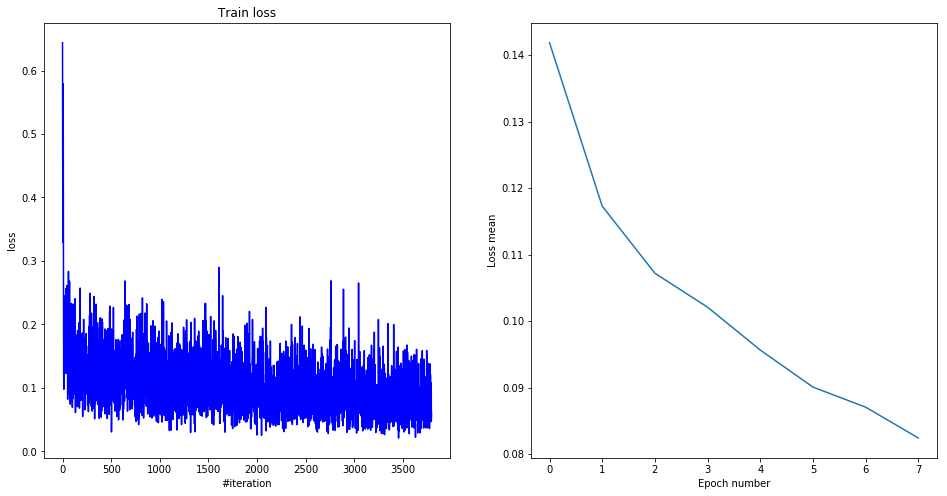

 14%|█▍        | 7/50 [9:06:22<55:56:19, 4683.25s/it]

Training...


A Jupyter Widget


Validation...


In [ ]:
for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    net.train(True)
    print("Training...")
    loss_sum = 0
    for X_batch, labels in tqdm_notebook(generate_batches_AR_all(train_data, Train_data_img, Train_data_seg, 
                                                train_indices, batch_size=batch_size)):
        cur_loss = []
        X_step = X_batch[0,:,:,:,:]
        labels_step = labels[0,:,:,:]
        labels_step = labels_step.reshape(labels_step.shape[0], 1, 
                                          labels_step.shape[1], labels_step.shape[2])
        X_step = Variable(X_step)
        labels_step = Variable(labels_step)
        if torch.cuda.is_available():
            X_step = X_step.cuda()
            labels_step = labels_step.cuda()
        out = net(X_step)
        loss = compute_loss(out,def_h,def_w,labels_step,'BCE')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cur_loss.append(loss.cpu().data.numpy())
        ar_out = torch.zeros(X_step.shape[0], n_out, def_h, def_w)
        for step in range(n_out-1):
            X_step = X_batch[1+step,:,:,:,:]
            ar_out[:,step,:,:] = out.detach().data[:, 0]
            upper = step + 1
            lower = max(upper-n_frames+1,0)
            X_step[:,-min(upper,n_frames-1):,:,:] = ar_out[:,lower:upper,:,:]
            labels_step = labels[1+step,:,:,:]
            labels_step = labels_step.reshape(labels_step.shape[0], 1, 
                                          labels_step.shape[1], labels_step.shape[2])

            X_step = Variable(X_step)
            labels_step = Variable(labels_step)
            if torch.cuda.is_available():
                X_step = X_step.cuda()
                labels_step = labels_step.cuda()
            out = net(X_step)
            loss = compute_loss(out,def_h,def_w,labels_step,'BCE')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            cur_loss.append(loss.cpu().data.numpy())
            #new_out = out.detanew_outch().data
        loss_num = np.mean(cur_loss)
        loss_sum += loss_num
        train_loss.append(loss_num)

    del loss, X_batch, labels, X_step, labels_step, ar_out, out
    torch.cuda.empty_cache()

    train_loss_mean.append(loss_sum / number_of_batches_train)
    
    net.eval()
    inner_acc = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_miou = np.zeros((n_out, number_of_batches_val),dtype = float)
    inner_iou = np.zeros((n_out, number_of_batches_val,n_classes),dtype = float)
    
    #save_model(net, optimizer, epoch, os.path.join(save_dir, '{}_epoch.ckpt'.format(epoch)))
    
    print("Validation...")
    counter = 0
    for X_batch, labels in generate_batches_AR_all(val_data, Val_data_img, Val_data_seg, 
                                                val_indices, batch_size=batch_size):
        X_step = X_batch[0,:,:,:,:]
        with torch.no_grad():
            out = net(Variable(X_step).cuda())
        pred = out.cpu().data.numpy()
        pred[pred > 0.5] = 1.0
        pred[pred <= 0.5] = 0.0
                
        pred = pred.reshape(X_step.shape[0], def_h, def_w)
        
        acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[0,:,:,:].numpy().astype(int),
                                                   n_classes=2)
        inner_acc[0,counter] = acc_loc
        inner_miou[0,counter] = miou_loc
        inner_iou[0,counter,:] = iou_loc
        ar_out = torch.zeros(X_step.shape[0], n_out, def_h, def_w)
        for step in range(n_out-1):
            X_step = X_batch[1+step,:,:,:,:]
            ar_out[:,step,:,:] = out.detach().data[:, 0]
            upper = step + 1
            lower = max(upper-n_frames+1,0)
            X_step[:,-min(upper,n_frames-1):,:,:] = ar_out[:,lower:upper,:,:]
            X_step = Variable(X_step)
            if torch.cuda.is_available():
                X_step = X_step.cuda()
            out = net(X_step)
            pred = out.cpu().data.numpy()
            pred[pred > 0.5] = 1.0
            pred[pred <= 0.5] = 0.0

            pred = pred.reshape(X_step.shape[0], def_h, def_w)
            
            acc_loc,miou_loc,iou_loc = compute_metrics(pred.astype(int),labels[1+step,:,:,:].numpy().astype(int),
                                                       n_classes=2)
            inner_acc[1+step,counter] = acc_loc
            inner_miou[1+step,counter] = miou_loc
            inner_iou[1+step,counter,:] = iou_loc
        counter += 1
        
    del X_batch, labels, X_step
    torch.cuda.empty_cache()
    
    cur_acc = inner_acc.mean(axis = 1)
    cur_miou = inner_miou.mean(axis = 1)
    cur_iou = inner_iou.mean(axis = 1)
    
    display.clear_output(wait=True)
    
    cur_miou_mean = cur_miou.mean()
    if cur_miou_mean > best_val_miou:
        print("saving model on epoch number %d with val miou %.3f..." % 
             (epoch + 1, cur_miou_mean))
        torch.save(net.state_dict(), 'model_xs2s_ar_bce_nframes3_nout5.pt')
        best_val_miou = cur_miou_mean
        no_improvements = 0
    else:
        no_improvements += 1
        if no_improvements > no_improvements_threshold:
            print("There were no improvements during last %d epochs,\nending on epoch %d" % 
               (no_improvements_threshold, epoch + 1))
            break
    print("acc = ",cur_acc)
    print("cur_miou = ",cur_miou)
    print("cur_iou = ",cur_iou)
    acc.append(cur_acc)
    miou.append(cur_miou)
    iou.append(cur_iou)
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.plot(train_loss, 'b')
    plt.title("Train loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.subplot(122)
    plt.plot(train_loss_mean)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss mean')
    plt.show()

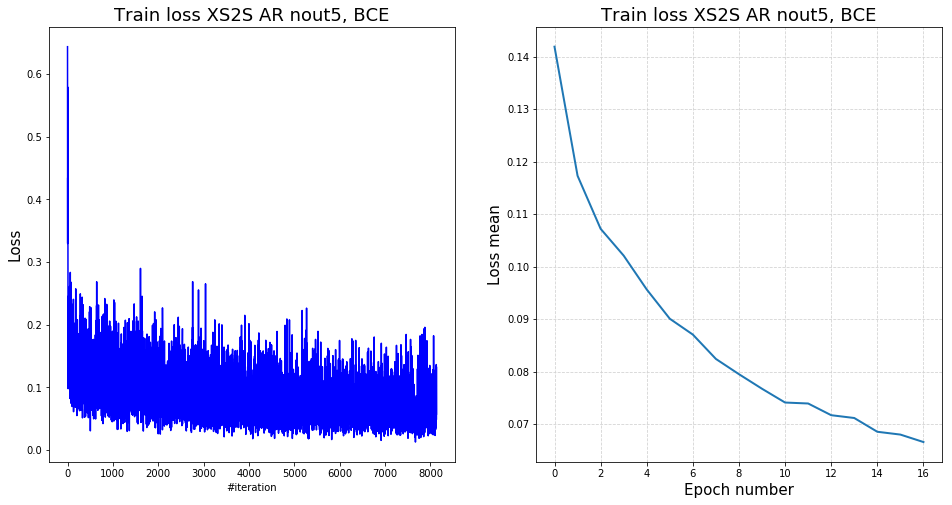

In [36]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(train_loss, 'b')
plt.title("Train loss XS2S AR nout5, BCE", size=18)
plt.xlabel("#iteration")
plt.ylabel("Loss", size=15)
plt.subplot(122)
plt.plot(train_loss_mean, lw=2)
plt.title("Train loss XS2S AR nout5, BCE", size=18)
plt.xlabel('Epoch number', size=15)
plt.ylabel('Loss mean', size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

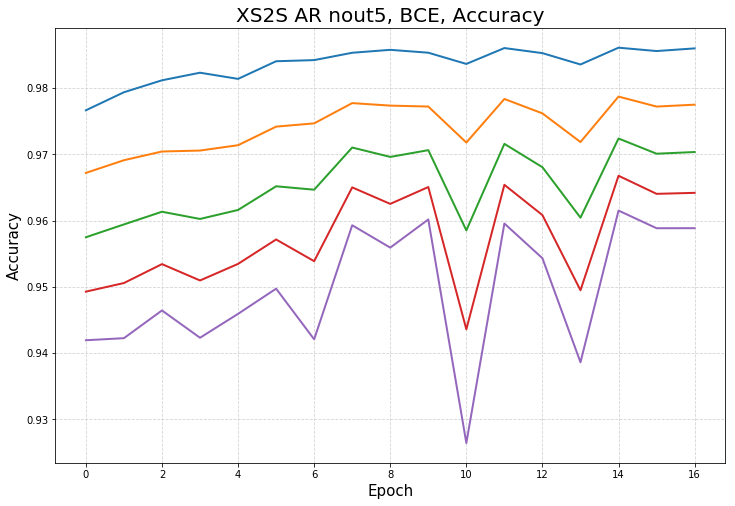

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(acc), lw=2)
plt.title("XS2S AR nout5, BCE, Accuracy", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("Accuracy", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

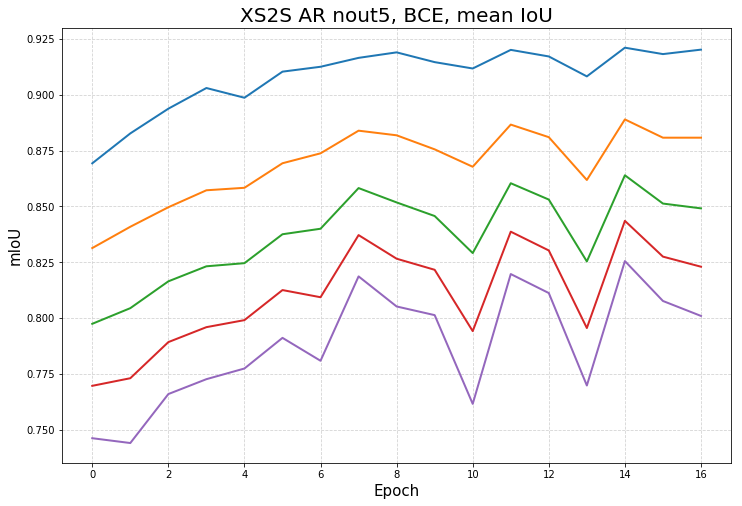

In [41]:
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(np.array(miou)[:,i], lw=2)
plt.title("XS2S AR nout5, BCE, mean IoU", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("mIoU", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.show()

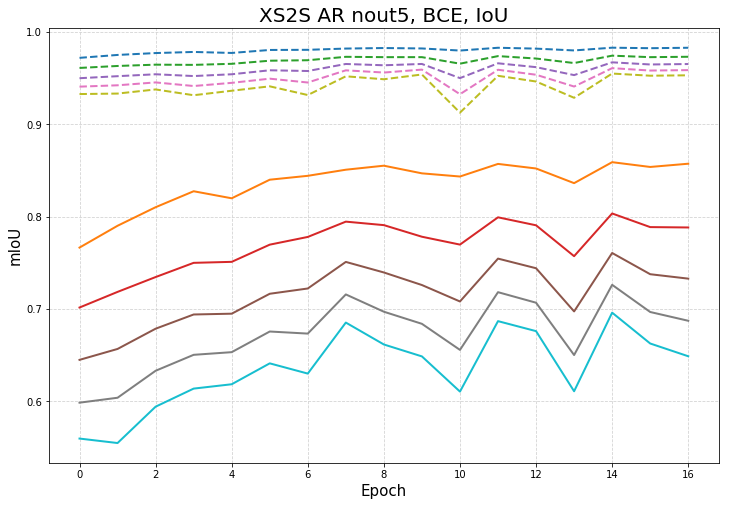

In [51]:
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(np.array(iou)[:,i,0], lw=2, linestyle="--")
    plt.plot(np.array(iou)[:,i,1], lw=2)
plt.title("XS2S AR nout5, BCE, IoU", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("mIoU", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.legend()
plt.show()

In [58]:
def save_files(acc, miou, iou, train_loss, train_loss_mean, path):
    d = {
        "acc": [list(x) for x in acc],
        "iou": [list(y) for x in iou for y in x],
        "miou": [list(x) for x in miou],
        "loss": [float(x) for x in train_loss],
        "loss_mean": [float(x) for x in train_loss_mean]
    }
    with open(path, 'w') as f:
        json.dump(d, f)

path = 'saved_files/xs2s_ar_bce_nout5.json'
save_files(acc, miou, iou, train_loss, train_loss_mean, path)

In [59]:
def load_files(path):
    with open(path) as f:
        d = json.load(f)
    return d

path = 'saved_files/xs2s_ar_bce_nout5.json'
res = load_files(path)

acc = res["acc"]
miou = res["miou"]
iou = res["iou"]
train_loss = res["loss"]
train_loss_mean = res["loss_mean"]

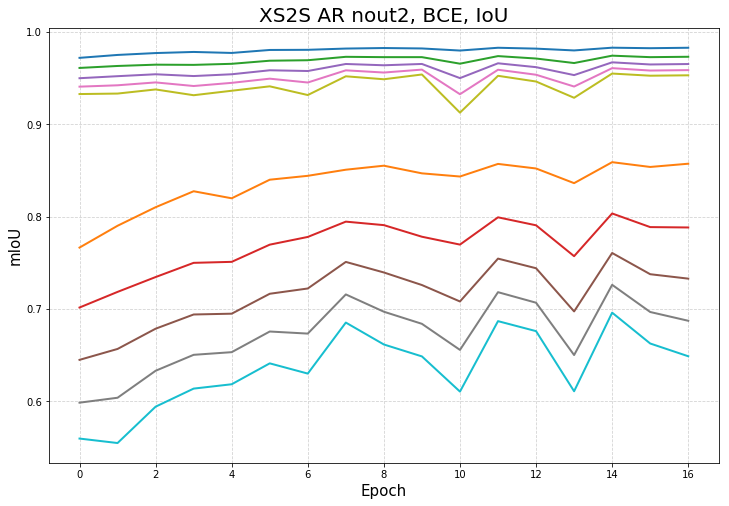

In [68]:
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(np.array(iou)[i::5], lw=2)
plt.title("XS2S AR nout2, BCE, IoU", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("mIoU", size=15)
plt.grid(color='lightgray', linestyle='dashed')
plt.legend()
plt.show()